In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

from torchsummary import summary

import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda:0")

In [ ]:
# ToTensor() turns images to tensors and scales pixels from [0, 255] to [0, 1].
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.CIFAR10(root='./', train=True, transform=transform, download=True)
test_dataset  = torchvision.datasets.CIFAR10(root='./', train=False, transform=transform, download=True)

train_dataset, val_dataset = random_split(train_dataset, [45000, 5000])

100%|██████████| 170M/170M [00:03<00:00, 48.4MB/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


In [ ]:
print("Single Image: ", train_dataset[0][0].shape)

Single Image:  torch.Size([3, 32, 32])


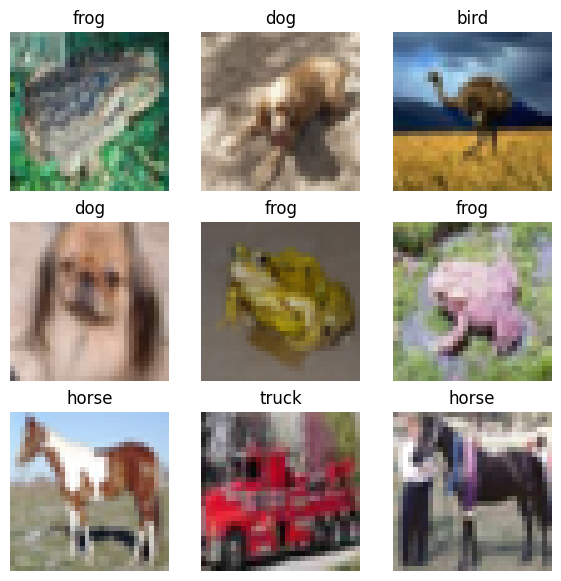

In [ ]:
plt.figure(figsize=(7, 7))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    image, label = train_dataset[i]
    plt.imshow(image.permute(1, 2, 0))
    plt.title(test_dataset.classes[label])
    plt.axis(False)

In [ ]:
# Mini-batch Stochastic Gradient Descent.
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
val_dataloader   = DataLoader(val_dataset,  batch_size=64, drop_last=True)
test_dataloader  = DataLoader(test_dataset, batch_size=64, drop_last=True)

In [ ]:
print("Number of training batches: ", len(train_dataloader))

Number of training batches:  703


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Learn and Extract Features.
        self.conv_layer_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3) # 32 kernels.
        self.pool_layer = nn.MaxPool2d(kernel_size=2)
        self.conv_layer_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3) # 64 kernels.
        self.conv_layer_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3) # 128 kernels.

        # Classification.
        self.hidden_layer = nn.Linear(in_features=128*2*2, out_features=256) # 256 perceptrons.
        self.output_layer = nn.Linear(in_features=256, out_features=10) # 10 perceptrons.

    def forward(self, inputs):
        # Learn and Extract Features.
        feature_maps = self.pool_layer(F.relu(self.conv_layer_1(inputs))) # 32 Feature maps of size 15x15.
        feature_maps = self.pool_layer(F.relu(self.conv_layer_2(feature_maps))) # 64 Feature maps size of size 6x6.
        feature_maps = self.pool_layer(F.relu(self.conv_layer_3(feature_maps))) # 128 Feature maps of size 2x2.

        # Classification.
        flattened_feature_maps = torch.flatten(feature_maps, start_dim=1)
        current_output = F.relu(self.hidden_layer(flattened_feature_maps))
        current_output = self.output_layer(current_output) # nn.CrossEntropyLoss() does the softmax for us.
        return current_output

In [ ]:
model = CNN().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 13, 13]          18,496
         MaxPool2d-4             [-1, 64, 6, 6]               0
            Conv2d-5            [-1, 128, 4, 4]          73,856
         MaxPool2d-6            [-1, 128, 2, 2]               0
            Linear-7                  [-1, 256]         131,328
            Linear-8                   [-1, 10]           2,570
Total params: 227,146
Trainable params: 227,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.40
Params size (MB): 0.87
Estimated Total Size (MB): 1.27
----------------------------------------------------------------


In [ ]:
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 10

train_losses_average_per_epoch = []
train_accuracies_average_per_epoch = []
val_losses_average_per_epoch = []
val_accuracies_average_per_epoch = []

for current_epoch in range(epochs):

    cumulative_accuracy_current_epoch, cumulative_loss_current_epoch = 0, 0

    for train_images_batch, train_labels_batch in train_dataloader:
        train_images_batch = train_images_batch.to(device)
        train_labels_batch = train_labels_batch.to(device)

        # Forward pass.
        outputs = model(train_images_batch)
        loss = loss_fun(outputs, train_labels_batch)

        # Backpropagation.
        loss.backward() # Compute gradients.
        optimizer.step() # Update weights.
        optimizer.zero_grad() # Update gradients to 0 for start of next batch.

        # Batch Loss.
        cumulative_loss_current_epoch += loss.item()

        # Batch Accuracy.
        preds = torch.argmax(outputs, dim=1)
        num_correct_preds = (preds == train_labels_batch).sum().item()
        batch_accuracy = num_correct_preds / len(train_labels_batch)
        cumulative_accuracy_current_epoch += batch_accuracy

    train_loss_average_current_epoch = cumulative_loss_current_epoch / len(train_dataloader)
    train_accuracy_average_current_epoch = cumulative_accuracy_current_epoch / len(train_dataloader)

    train_losses_average_per_epoch.append(train_loss_average_current_epoch)
    train_accuracies_average_per_epoch.append(train_accuracy_average_current_epoch)

    cumulative_accuracy_current_epoch, cumulative_loss_current_epoch = 0, 0

    with torch.no_grad():
        for val_images_batch, val_labels_batch in val_dataloader:
            val_images_batch = val_images_batch.to(device)
            val_labels_batch = val_labels_batch.to(device)

            # No Backpropagation, because we do not want to train with the val_dataset.
            outputs = model(val_images_batch)
            loss = loss_fun(outputs, val_labels_batch)

            # Batch Loss.
            cumulative_loss_current_epoch += loss.item()

            # Batch Accuracy.
            preds = torch.argmax(outputs, dim=1)
            num_correct_preds = (preds == val_labels_batch).sum().item()
            batch_accuracy = num_correct_preds / len(val_labels_batch)
            cumulative_accuracy_current_epoch += batch_accuracy

    val_loss_average_current_epoch = cumulative_loss_current_epoch / len(val_dataloader)
    val_accuracy_average_current_epoch = cumulative_accuracy_current_epoch / len(val_dataloader)

    val_losses_average_per_epoch.append(val_loss_average_current_epoch)
    val_accuracies_average_per_epoch.append(val_accuracy_average_current_epoch)

    print(
        f'Epoch {current_epoch + 1}  '
        f'Train Loss: {train_losses_average_per_epoch[current_epoch]:.2f} '
        f'Train Accuracy: {train_accuracies_average_per_epoch[current_epoch]:.2f} '
        f'Val Loss: {val_losses_average_per_epoch[current_epoch]:.2f} '
        f'Val Accuracy: {val_accuracies_average_per_epoch[current_epoch]:.2f}'
    )

Epoch 1  Train Loss: 1.66 Train Accuracy: 0.38 Val Loss: 1.46 Val Accuracy: 0.45
Epoch 2  Train Loss: 1.29 Train Accuracy: 0.53 Val Loss: 1.20 Val Accuracy: 0.57
Epoch 3  Train Loss: 1.12 Train Accuracy: 0.60 Val Loss: 1.10 Val Accuracy: 0.62
Epoch 4  Train Loss: 1.00 Train Accuracy: 0.65 Val Loss: 1.02 Val Accuracy: 0.64
Epoch 5  Train Loss: 0.92 Train Accuracy: 0.68 Val Loss: 0.94 Val Accuracy: 0.66
Epoch 6  Train Loss: 0.84 Train Accuracy: 0.71 Val Loss: 0.94 Val Accuracy: 0.67
Epoch 7  Train Loss: 0.78 Train Accuracy: 0.73 Val Loss: 0.95 Val Accuracy: 0.68
Epoch 8  Train Loss: 0.71 Train Accuracy: 0.75 Val Loss: 0.85 Val Accuracy: 0.70
Epoch 9  Train Loss: 0.67 Train Accuracy: 0.77 Val Loss: 0.85 Val Accuracy: 0.71
Epoch 10  Train Loss: 0.61 Train Accuracy: 0.79 Val Loss: 0.85 Val Accuracy: 0.71


In [ ]:
model.to("cpu")

cumulative_accuracy_current_epoch = 0

with torch.no_grad():
    for test_images_batch, test_labels_batch in test_dataloader:
        outputs = model(test_images_batch)

        # Batch Accuracy.
        preds = torch.argmax(outputs, dim=1)
        num_correct_preds = (preds == test_labels_batch).sum().item()
        batch_accuracy = num_correct_preds / len(test_labels_batch)
        cumulative_accuracy_current_epoch += batch_accuracy

print(f'Final test accuracy: {cumulative_accuracy_current_epoch / len(test_dataloader):.2%}')

Final test accuracy: 70.51%


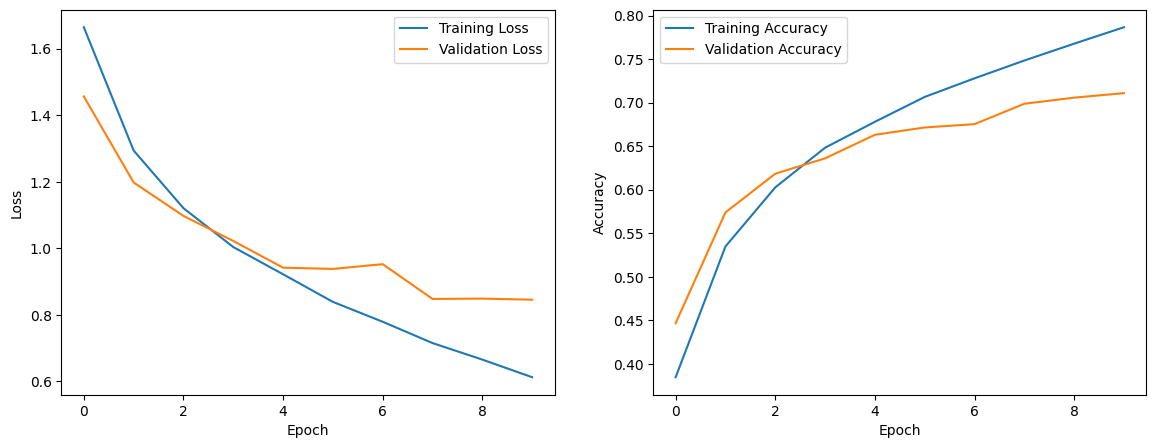

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

metrics = [
    (train_losses_average_per_epoch, val_losses_average_per_epoch, 'Loss'),
    (train_accuracies_average_per_epoch, val_accuracies_average_per_epoch, 'Accuracy')
]

for i, (train_data, val_data, metric_name) in enumerate(metrics):
    ax = axs[i]
    ax.plot(train_data, label='Training ' + metric_name)
    ax.plot(val_data, label='Validation ' + metric_name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric_name)
    ax.legend()

plt.show()

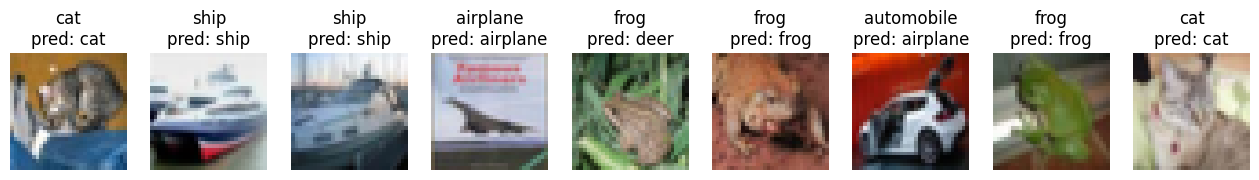

In [ ]:
plt.figure(figsize=(16, 8))

for i in range(9):
    plt.subplot(1, 9, i + 1)

    image, label = test_dataset[i]
    output = model(image.unsqueeze(0)) # unsqueeze to specify a batch size of 1.
    pred = torch.argmax(output, dim=1)

    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"{test_dataset.classes[label]}\npred: {test_dataset.classes[pred]}")
    plt.axis(False)